# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.insert(0, "../")
from transkit import pharma, fit, medications

In [5]:
t3_ec_cali = np.array([0.000000000, 0.246635358])
t2_ev_cali = np.array([0.000000000, 1.428689307])

calibrated_medications = dict(medications.medications)
calibrated_medications["ec"] = medications.calibratedDoseResponse(
    calibrated_medications["ec"],
    t3_ec_cali)
calibrated_medications["ev"] = medications.calibratedDoseResponse(
    calibrated_medications["ev"],
    t2_ev_cali)

# Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

## Menstrual

In [6]:
def molarConcToMassConc(molar_conc, molar_weight):
    """Converts pmol/L to pg/mL for a substance of a particular molar weight.
    
    molar         Molar concentration in pmol/L [array like].
    molar_weight  Molar weight of substance in g/mol."""
    return molar_conc * molar_weight * 10**-3


e2_mol = 272.388 # g/mol

# Stricker2006, referenced from https://en.wikiversity.org/wiki/WikiJournal_of_Medicine/Reference_ranges_for_estradiol,_progesterone,_luteinizing_hormone_and_follicle-stimulating_hormone_during_the_menstrual_cycle
menstrual_e2 = molarConcToMassConc(np.array([118.42, 133.01, 133.17, 125.95, 134.65, 151.33, 159.48, 170.34, 195.9, 228.2, 269.07, 343.68, 477.27, 661.19, 914.84, 780.76, 320.59, 261.32, 338.94, 454.07, 499.49, 497.07, 531.14, 504.39, 499.18, 526.68, 350.65, 322.24, 229.7, 249.28, 150.0, 118.42, 118.42, 118.42, 118.42]),
                                   e2_mol)

menstrual_fit_start_t = pd.to_datetime("2020-01-01 12:00:00")
menstrual_fit_range_t = 6*7 - 1 + len(menstrual_e2) # 6 weeks to steady state, then the menstrual curve.
menstrual_fit_t  = pd.date_range(menstrual_fit_start_t,
                                 menstrual_fit_start_t + pd.to_timedelta(menstrual_fit_range_t, unit='D'),
                                 freq='1D')
menstrual_fit_e2 = np.append(np.full(6*7, menstrual_e2[0]), menstrual_e2)

menstrual_fit = pd.Series(menstrual_fit_e2, index=menstrual_fit_t)
menstrual_fit_results = fit.emptyResults()

### Estradiol Cypionate

Least squares figures out some real gymnastics to get this close, but EC doesn't decay quickly enough to mimic the big peak very well. I wonder if this result is still in range for some realistic cycle, even if it doesn't quite match the mean?

In [11]:
doses = pharma.createDosesCycle(
    "ec",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ec"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:13]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[12]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ec"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0858e+04                                    9.81e+04    
       1              2         3.5645e+04      2.52e+04       2.11e+00       1.71e+04    
       2              3         2.7436e+04      8.21e+03       7.75e-01       1.19e+04    
       3              4         2.1156e+04      6.28e+03       1.60e+00       5.40e+03    
       4              5         1.9263e+04      1.89e+03       5.47e-01       2.54e+04    
       5              6         1.9096e+04      1.67e+02       9.64e-02       6.96e+03    
       6              7         1.8160e+04      9.35e+02       6.94e-01       3.18e+03    
       7              8         1.7142e+04      1.02e+03       4.12e-01       1.82e+04    
       8              9         1.7040e+04      1.02e+02       7.57e-02       4.77e+03    
       9             10         1.6621e+04      4.19e+02       4.08e-01       2.05e+03    

Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.425         ec
2020-01-04 12:00:00.000000000      0.425         ec
2020-01-07 12:00:00.000000000      0.425         ec
2020-01-10 12:00:00.000000000      0.425         ec
2020-01-13 12:00:00.000000000      0.425         ec
2020-01-16 12:00:00.000000000      0.425         ec
2020-01-19 12:00:00.000000000      0.425         ec
2020-01-22 12:00:00.000000000      0.425         ec
2020-01-25 12:00:00.000000000      0.425         ec
2020-01-28 12:00:00.000000000      0.425         ec
2020-01-31 12:00:00.000000000      0.425         ec
2020-02-03 12:00:00.000000000      0.425         ec
2020-02-06 12:00:00.000000000      0.425         ec
2020-02-09 12:00:00.000000000      0.538         ec
2020-02-12 12:26:01.613904000      0.464         ec
2020-02-15 19:11:32.258342400      1.071         ec
2020-02-18 21:20:07.063123200      2.159         ec
2020-02-21 20:52:47.738121600      4.082      

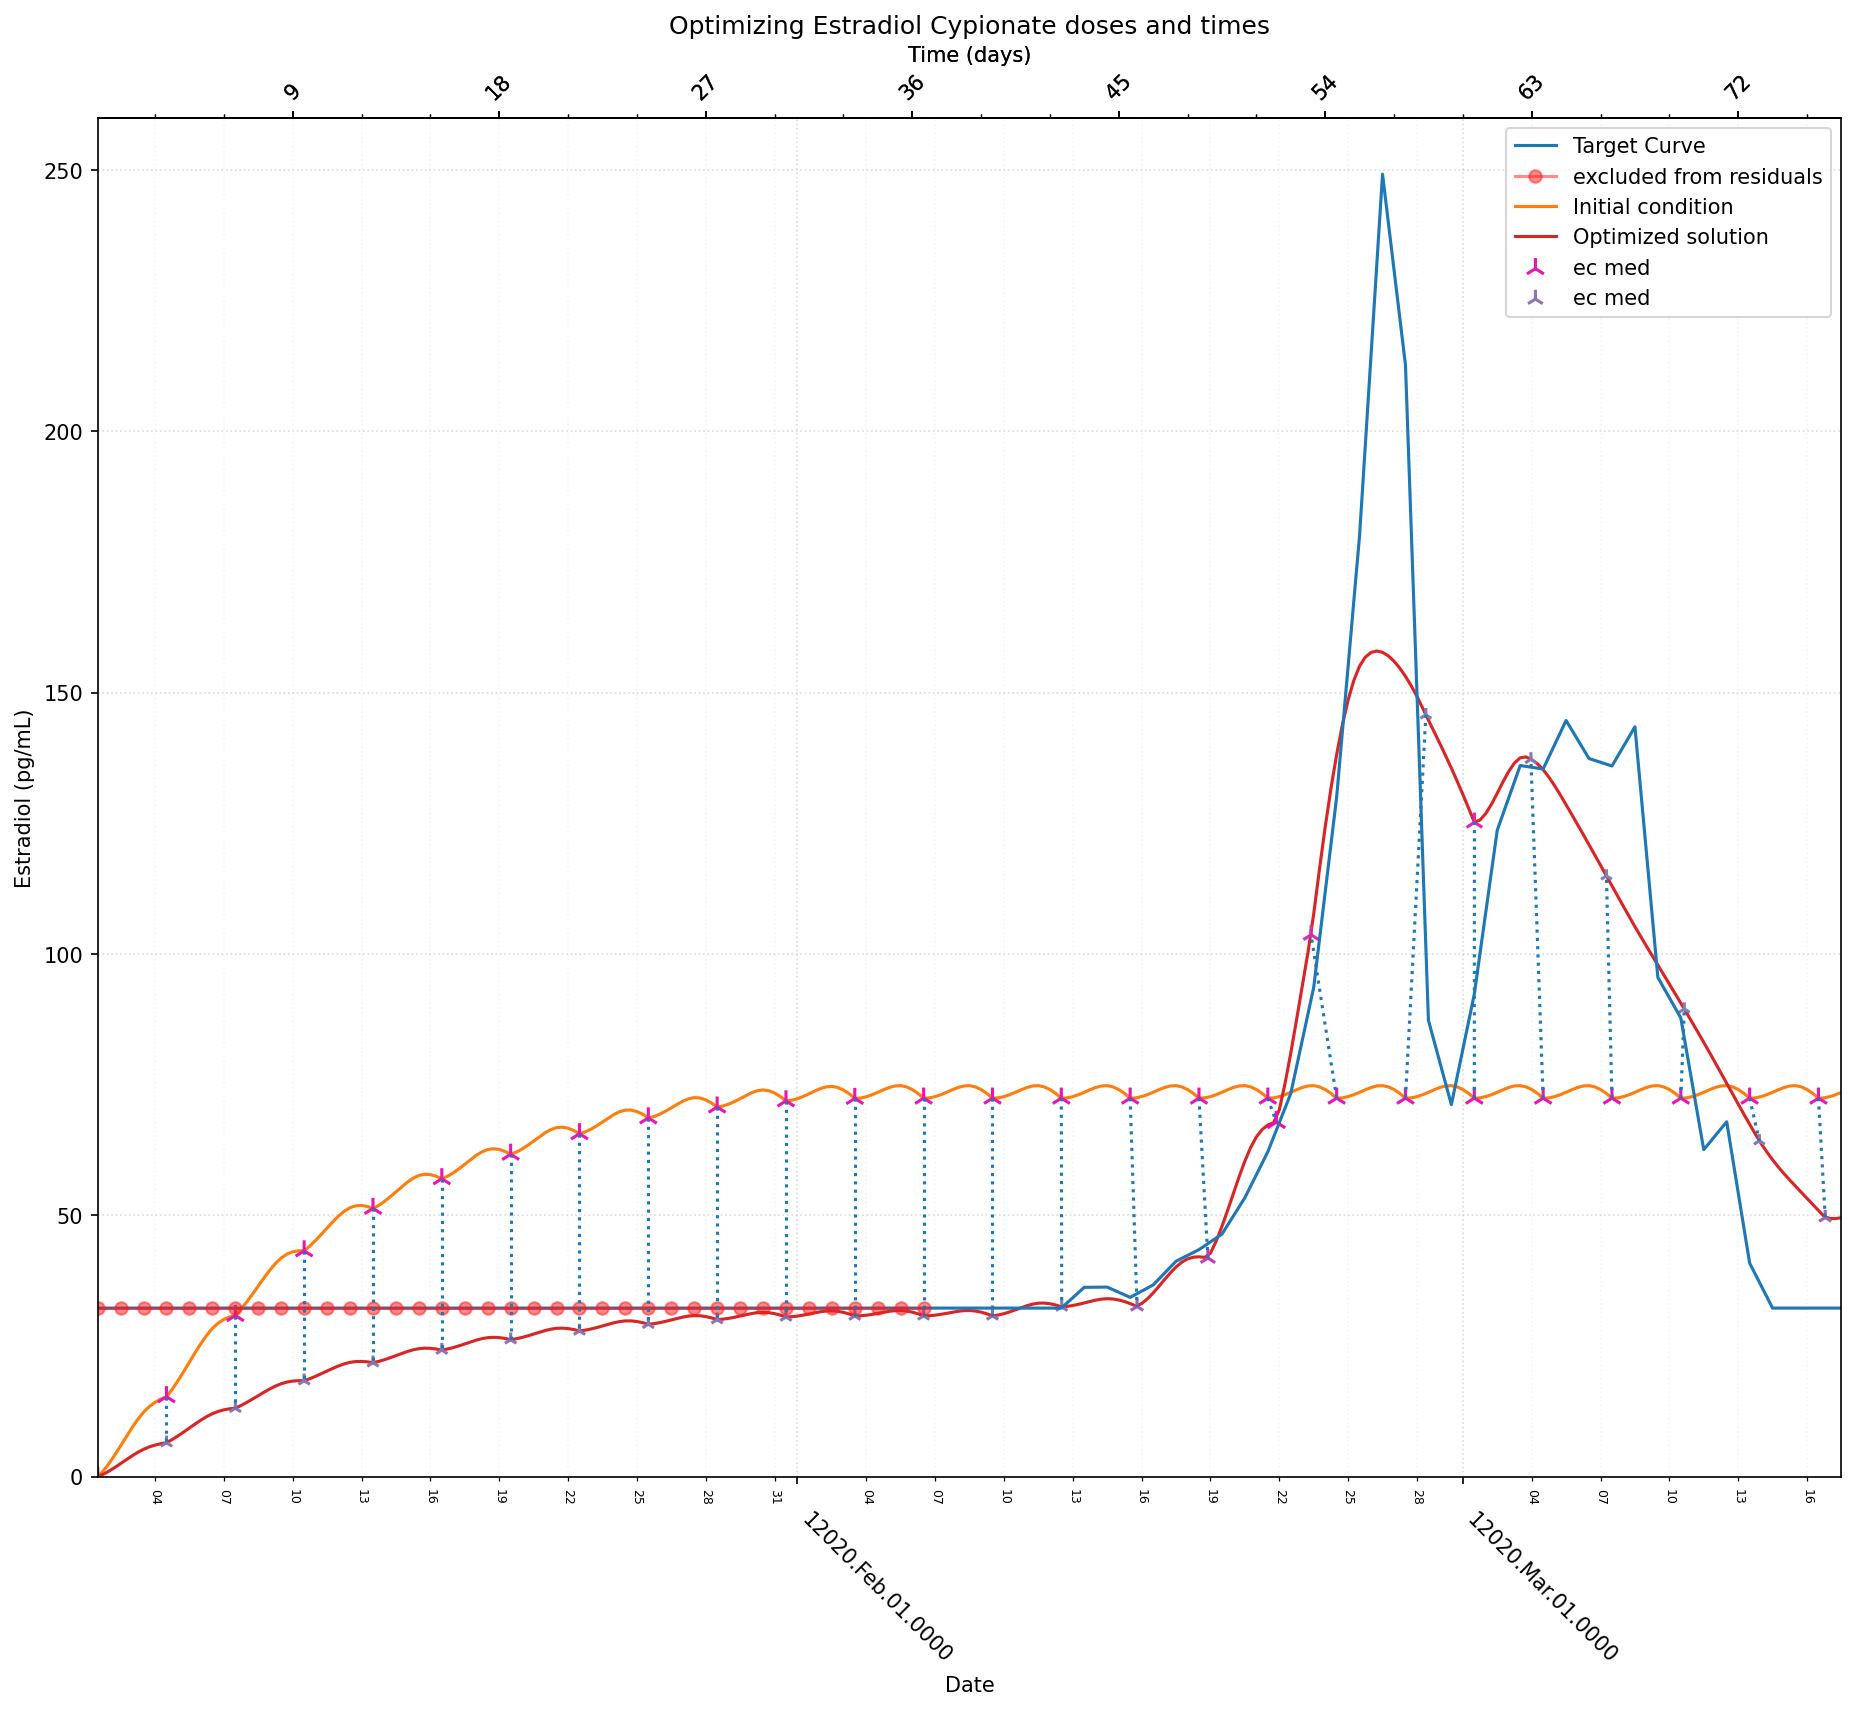

In [12]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ec"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ec"]["doses_optim"])

### Estradiol Valerate

After all this work, it looks like EV can actually fit a realistic menstrual curve better than EC can. Wow! That's incredibly unexpected for me but I guess I was doing all of the curve fitting stuff at unrealistic time scales. The interesting bit here is that, because of the big intense spike in estradiol prior to ovulation, the decay rate of EC isn't able to keep up. EV, with it's big quick peak, and fast decay, is perfectly suited to mimicing that peak in estradiol.

Somatically it's almost like taking EV is like ovulating with every injection–and that actually resonates with my subjective experience pretty well. EV has a kind of dynamicism and responsiveness and punchiness to it. EC is much softer, pillowy, flowy, floaty. EV is unsurprisingly well suited to fitting to quicker, more dynamic curves; EC is better suited to gentler, more stable curves. They each have strengths. I have no idea how you'd get it prescribed, but I wonder if mixing medicines could work. Like using EC for most injections, but using EV for just around the big peak. Or maybe spiking with pills there. Once you've figured out the calibration for your body, a whole lot of magic is possible!

At realistic time scales there's a lot more to "stable levels" than just optimizing for constant e2 levels, that's for sure! I feel a bit sad and disappointed, and I wish I had done this piece with a real menstrual cycle curve much sooner. I am feeling a big expansion in my understanding of all this though, and how it fits together somatically. It's not what I was expecting, and that's really exciting! Laying it all out on a timeline is really important. I feel some inklings and sparking connections happening...

In [13]:
doses = pharma.createDosesCycle(
    "ev",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ev"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:14]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[13]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ev"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2308e+05                                    1.97e+05    
       1              2         1.0400e+05      3.19e+05       1.24e+00       3.91e+04    
       2              3         2.3627e+04      8.04e+04       7.68e-01       1.07e+05    
       3              4         1.9291e+04      4.34e+03       3.40e-01       1.32e+04    
       4              5         8.1356e+03      1.12e+04       3.66e-01       8.28e+04    
       5              6         7.2822e+03      8.53e+02       1.27e-01       4.20e+03    
       6              7         3.9831e+03      3.30e+03       2.80e-01       3.22e+04    
       7              8         3.8293e+03      1.54e+02       5.04e-02       3.53e+03    
       8              9         3.6678e+03      1.61e+02       8.18e-02       1.81e+03    
       9             10         3.2982e+03      3.70e+02       1.10e-01       2.38e+04    

Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.147         ev
2020-01-04 12:00:00.000000000      0.147         ev
2020-01-07 12:00:00.000000000      0.147         ev
2020-01-10 12:00:00.000000000      0.147         ev
2020-01-13 12:00:00.000000000      0.147         ev
2020-01-16 12:00:00.000000000      0.147         ev
2020-01-19 12:00:00.000000000      0.147         ev
2020-01-22 12:00:00.000000000      0.147         ev
2020-01-25 12:00:00.000000000      0.147         ev
2020-01-28 12:00:00.000000000      0.147         ev
2020-01-31 12:00:00.000000000      0.147         ev
2020-02-03 12:00:00.000000000      0.147         ev
2020-02-06 12:00:00.000000000      0.147         ev
2020-02-09 12:00:00.000000000      0.147         ev
2020-02-12 13:07:40.803196800      0.168         ev
2020-02-15 16:32:49.416230400      0.204         ev
2020-02-18 20:53:45.174163200      0.309         ev
2020-02-21 23:40:28.509484800      0.565      

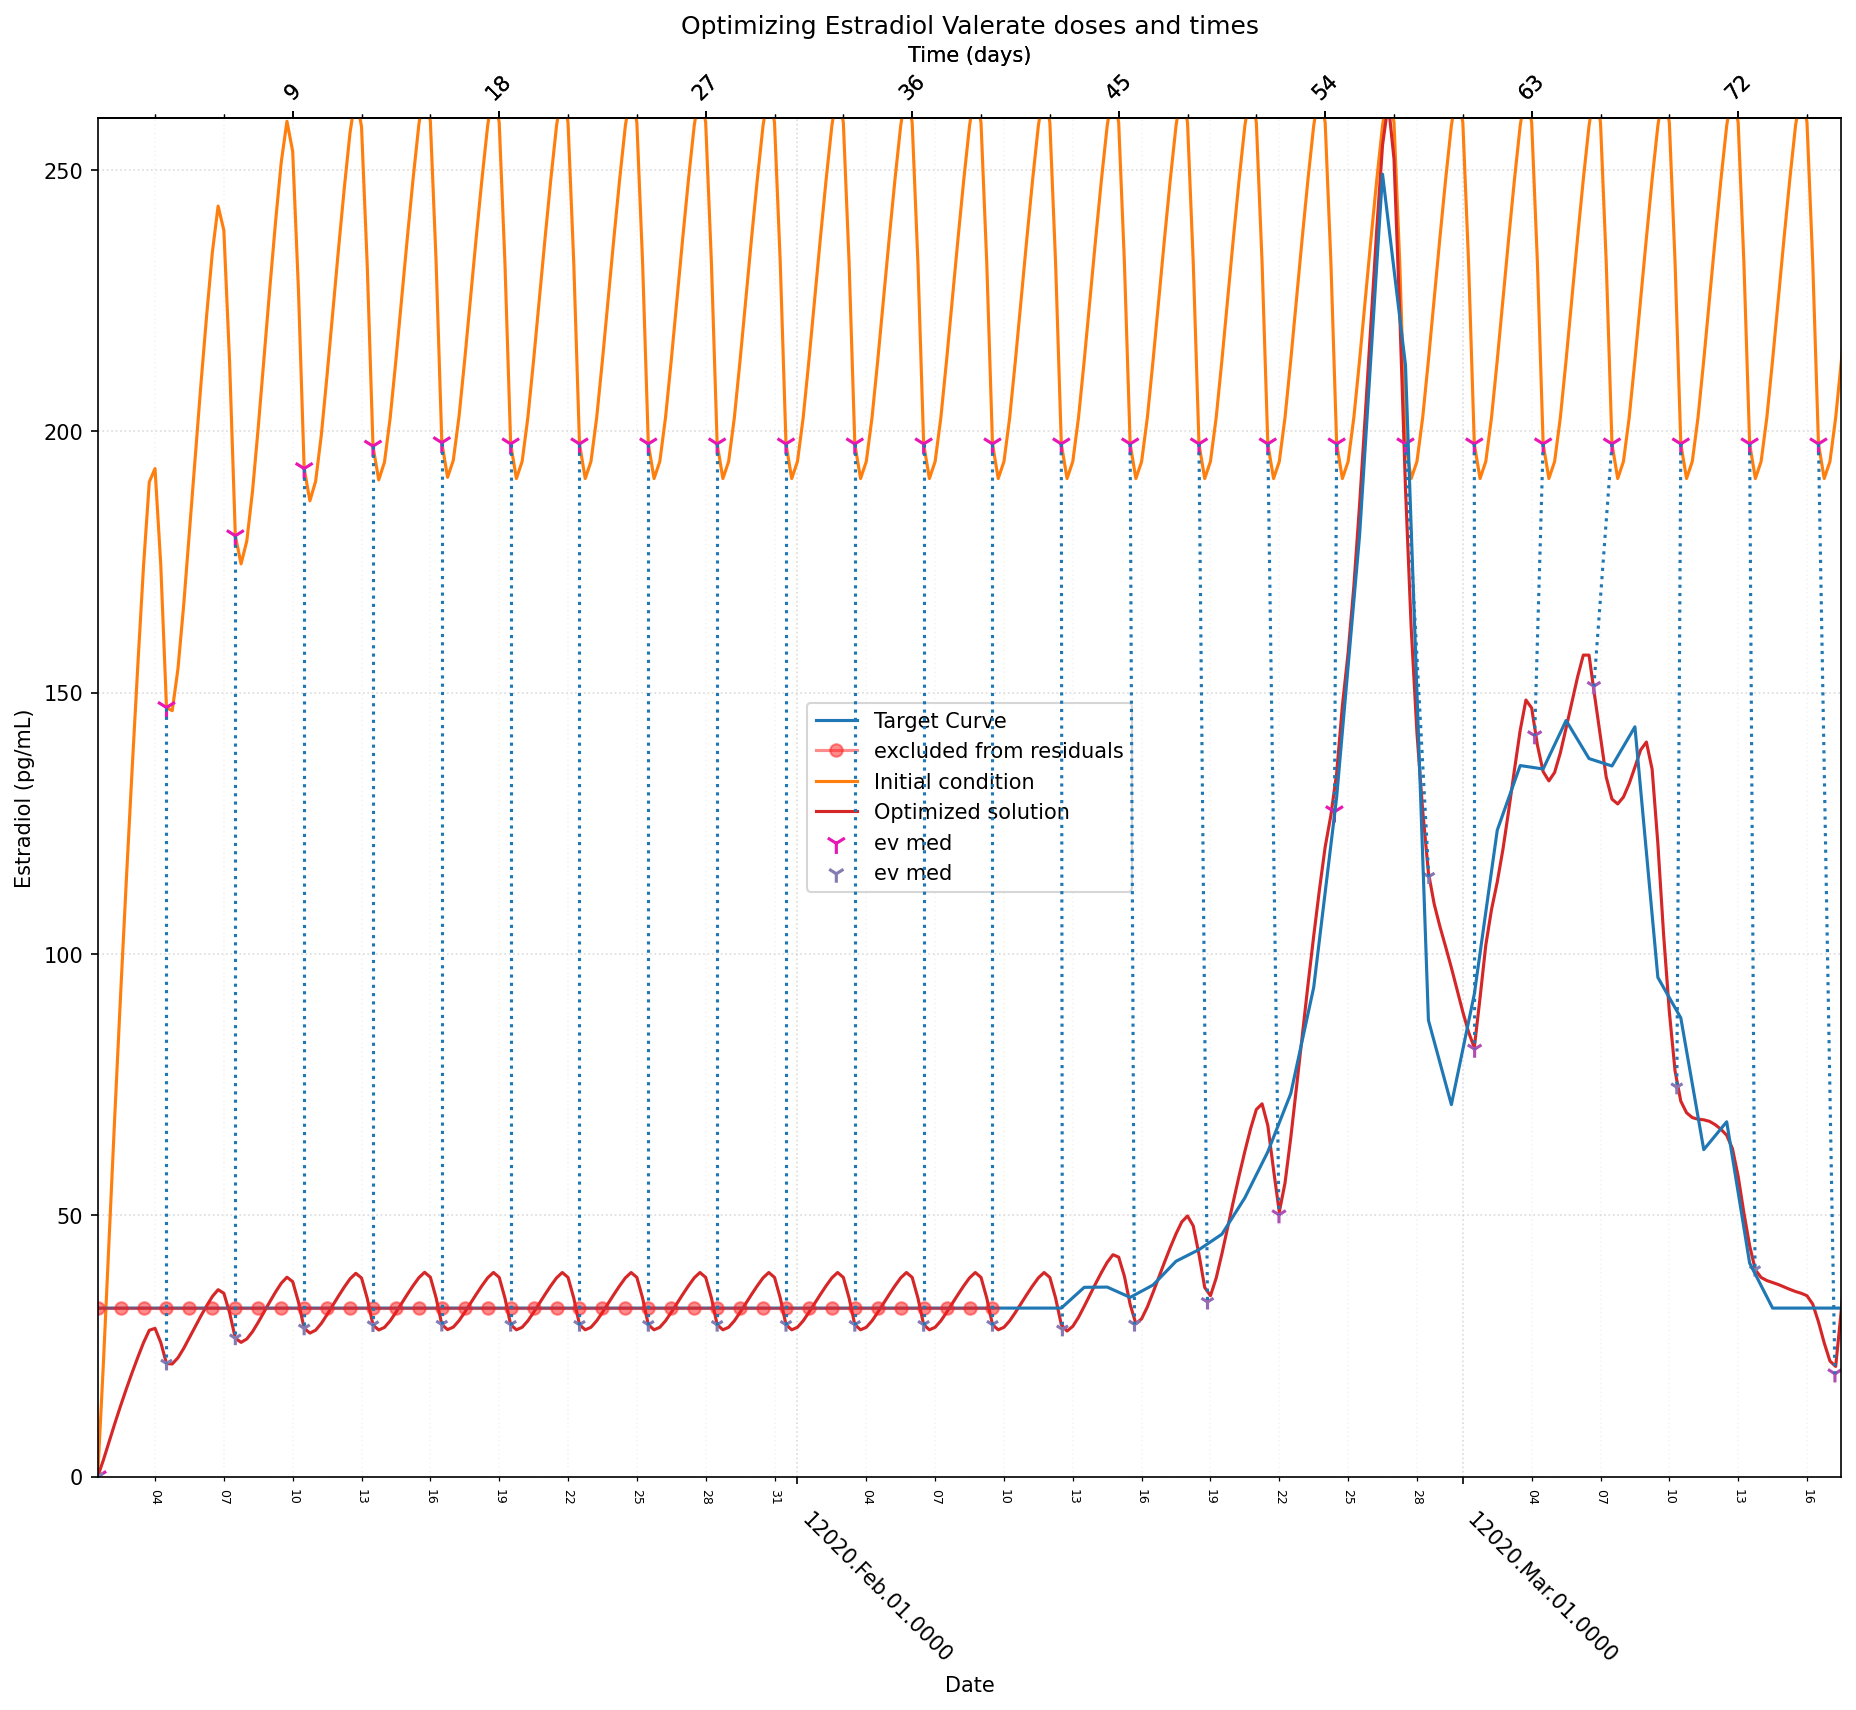

In [15]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ev"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ev"]["doses_optim"])

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [16]:
cycling_start_t = 42.0 # days
sine_target_func = lambda T: int(T>=cycling_start_t) * (250.0 + 50.0*np.sin((2*math.pi/30)*(T-cycling_start_t))) +\
                             int(T<cycling_start_t)  * (250.0)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(90.0, unit='D'), freq='18H')
sine_target_y = np.array([sine_target_func(pharma.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

sine_target = pd.Series(sine_target_y, index=sine_target_x)
sine_results = fit.emptyResults()

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [17]:
sine_results["ec_doses"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020"),
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds='fixed')
fit.runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         5.5495e+05      1.65e+06       8.46e+00       8.44e+04    
       2              3         2.3290e+05      3.22e+05       4.14e+00       2.35e+04    
       3              4         1.7248e+05      6.04e+04       1.90e+00       1.29e+04    
       4              5         1.5692e+05      1.56e+04       1.40e+00       4.62e+03    
       5              6         1.5177e+05      5.14e+03       6.34e-01       4.77e+03    
       6              7         1.4992e+05      1.85e+03       5.28e-01       1.99e+03    
       7              8         1.4822e+05      1.70e+03       3.64e-01       2.82e+03    
       8              9         1.4759e+05      6.28e+02       3.03e-01       1.30e+03    
       9             10         1.4686e+05      7.34e+02       2.28e-01       1.81e+03    

Optimized Doses:
                  dose medication
2020-01-01      5.000         ec
2020-01-04      5.000         ec
2020-01-07      4.987         ec
2020-01-10      4.348         ec
2020-01-13      3.228         ec
2020-01-16      3.228         ec
2020-01-19      3.191         ec
2020-01-22      3.095         ec
2020-01-25      3.138         ec
2020-01-28      3.330         ec
2020-01-31      3.454         ec
2020-02-03      3.391         ec
2020-02-06      3.372         ec
2020-02-09      3.980         ec
2020-02-12      4.646         ec
2020-02-15      4.601         ec
2020-02-18      4.054         ec
2020-02-21      2.940         ec
2020-02-24      2.172         ec
2020-02-27      1.880         ec
2020-03-01      2.034         ec
2020-03-04      2.738         ec
2020-03-07      4.003         ec
2020-03-10      4.652         ec
2020-03-13      4.802         ec
2020-03-16      4.707         ec
2020-03-19      4.206         ec
2020-03-22      2.929         ec
2020-03-25      2.124    

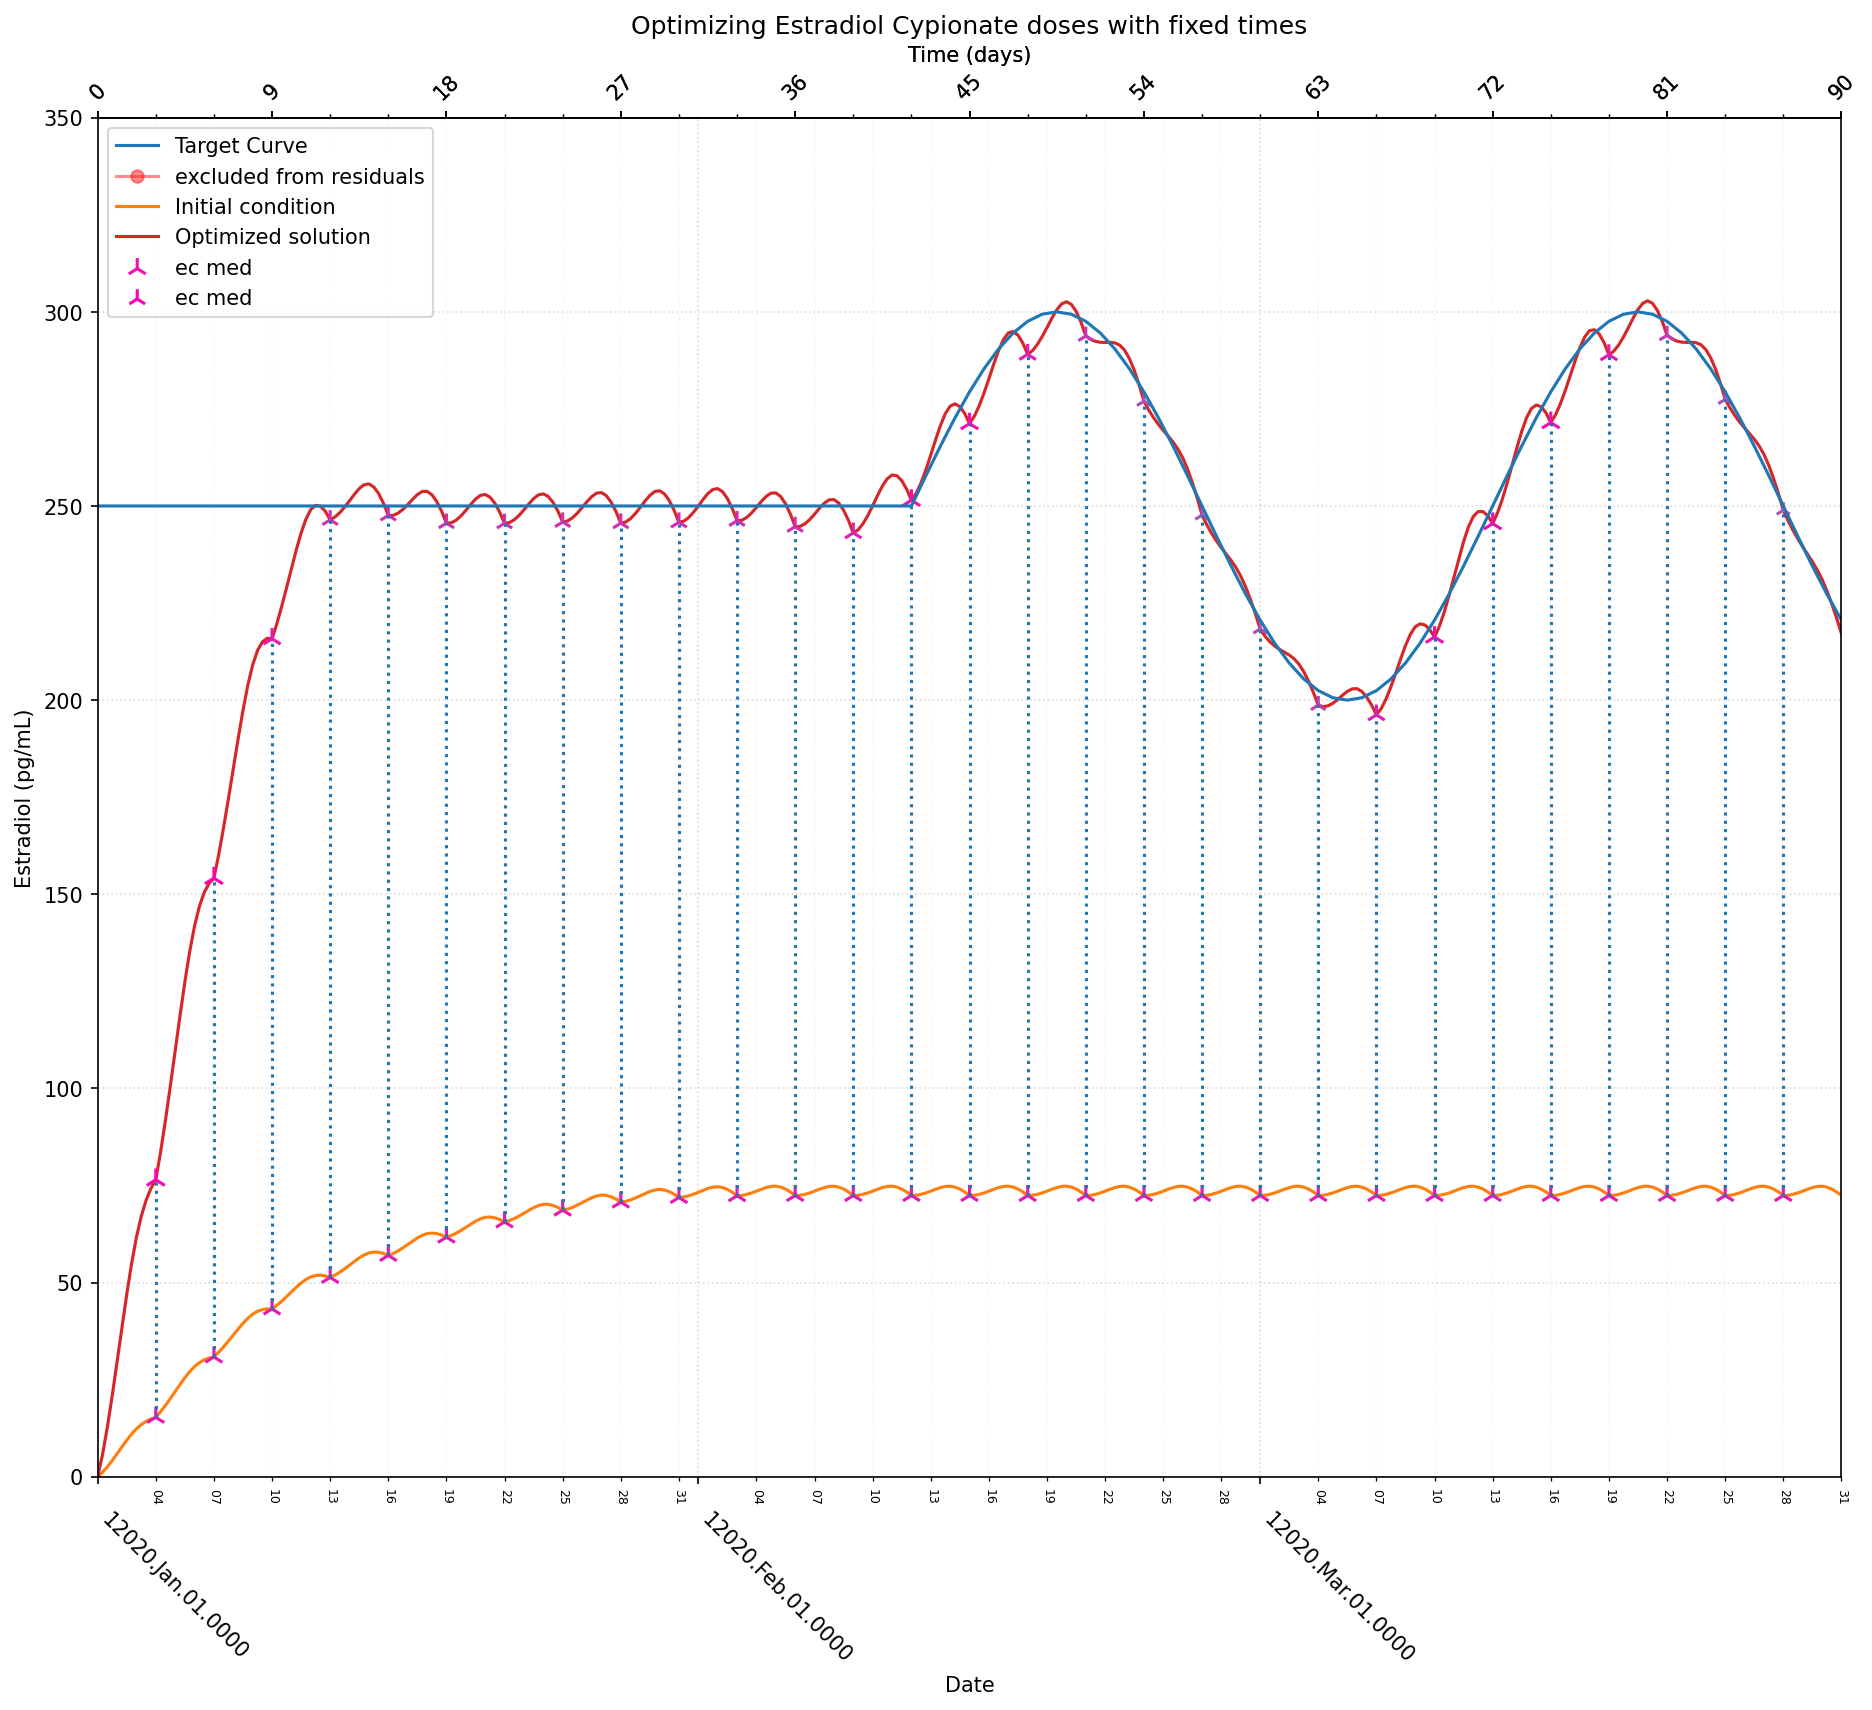

In [18]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses with fixed times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses"]["doses_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [19]:
doses = pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020")
sine_results["ec_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=30,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         5.5411e+05      1.65e+06       8.46e+00       8.44e+04    
       2              3         2.2717e+05      3.27e+05       4.17e+00       2.30e+04    
       3              4         1.5523e+05      7.19e+04       2.12e+00       1.20e+04    
       4              5         1.3341e+05      2.18e+04       1.56e+00       5.01e+03    
       5              6         1.2449e+05      8.92e+03       8.07e-01       4.81e+03    
       6              7         1.2125e+05      3.24e+03       5.59e-01       2.69e+03    
       7              8         1.1807e+05      3.17e+03       4.85e-01       3.34e+03    
       8              9         1.1724e+05      8.39e+02       2.86e-01       1.51e+03    
       9             10         1.1589e+05      1.34e+03       2.65e-01       1.96e+03    

Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      5.000         ec
2020-01-02 12:00:00.000000000      5.000         ec
2020-01-05 12:00:48.537792000      4.982         ec
2020-01-08 19:07:39.186566400      4.486         ec
2020-01-12 11:18:18.077702400      3.987         ec
2020-01-15 16:23:59.151264000      3.451         ec
2020-01-18 20:46:40.742112000      3.235         ec
2020-01-22 01:59:35.160230400      3.221         ec
2020-01-25 03:25:15.617395199      3.286         ec
2020-01-28 04:02:46.596249600      3.371         ec
2020-01-31 03:36:03.895862400      3.463         ec
2020-02-03 03:32:43.354550399      3.522         ec
2020-02-06 05:11:06.928396800      3.597         ec
2020-02-09 10:42:25.824499200      3.819         ec
2020-02-12 04:19:40.979078400      4.273         ec
2020-02-14 16:06:49.490841600      4.204         ec
2020-02-17 11:47:44.614176000      3.851         ec
2020-02-20 11:49:35.486198400      3.205      

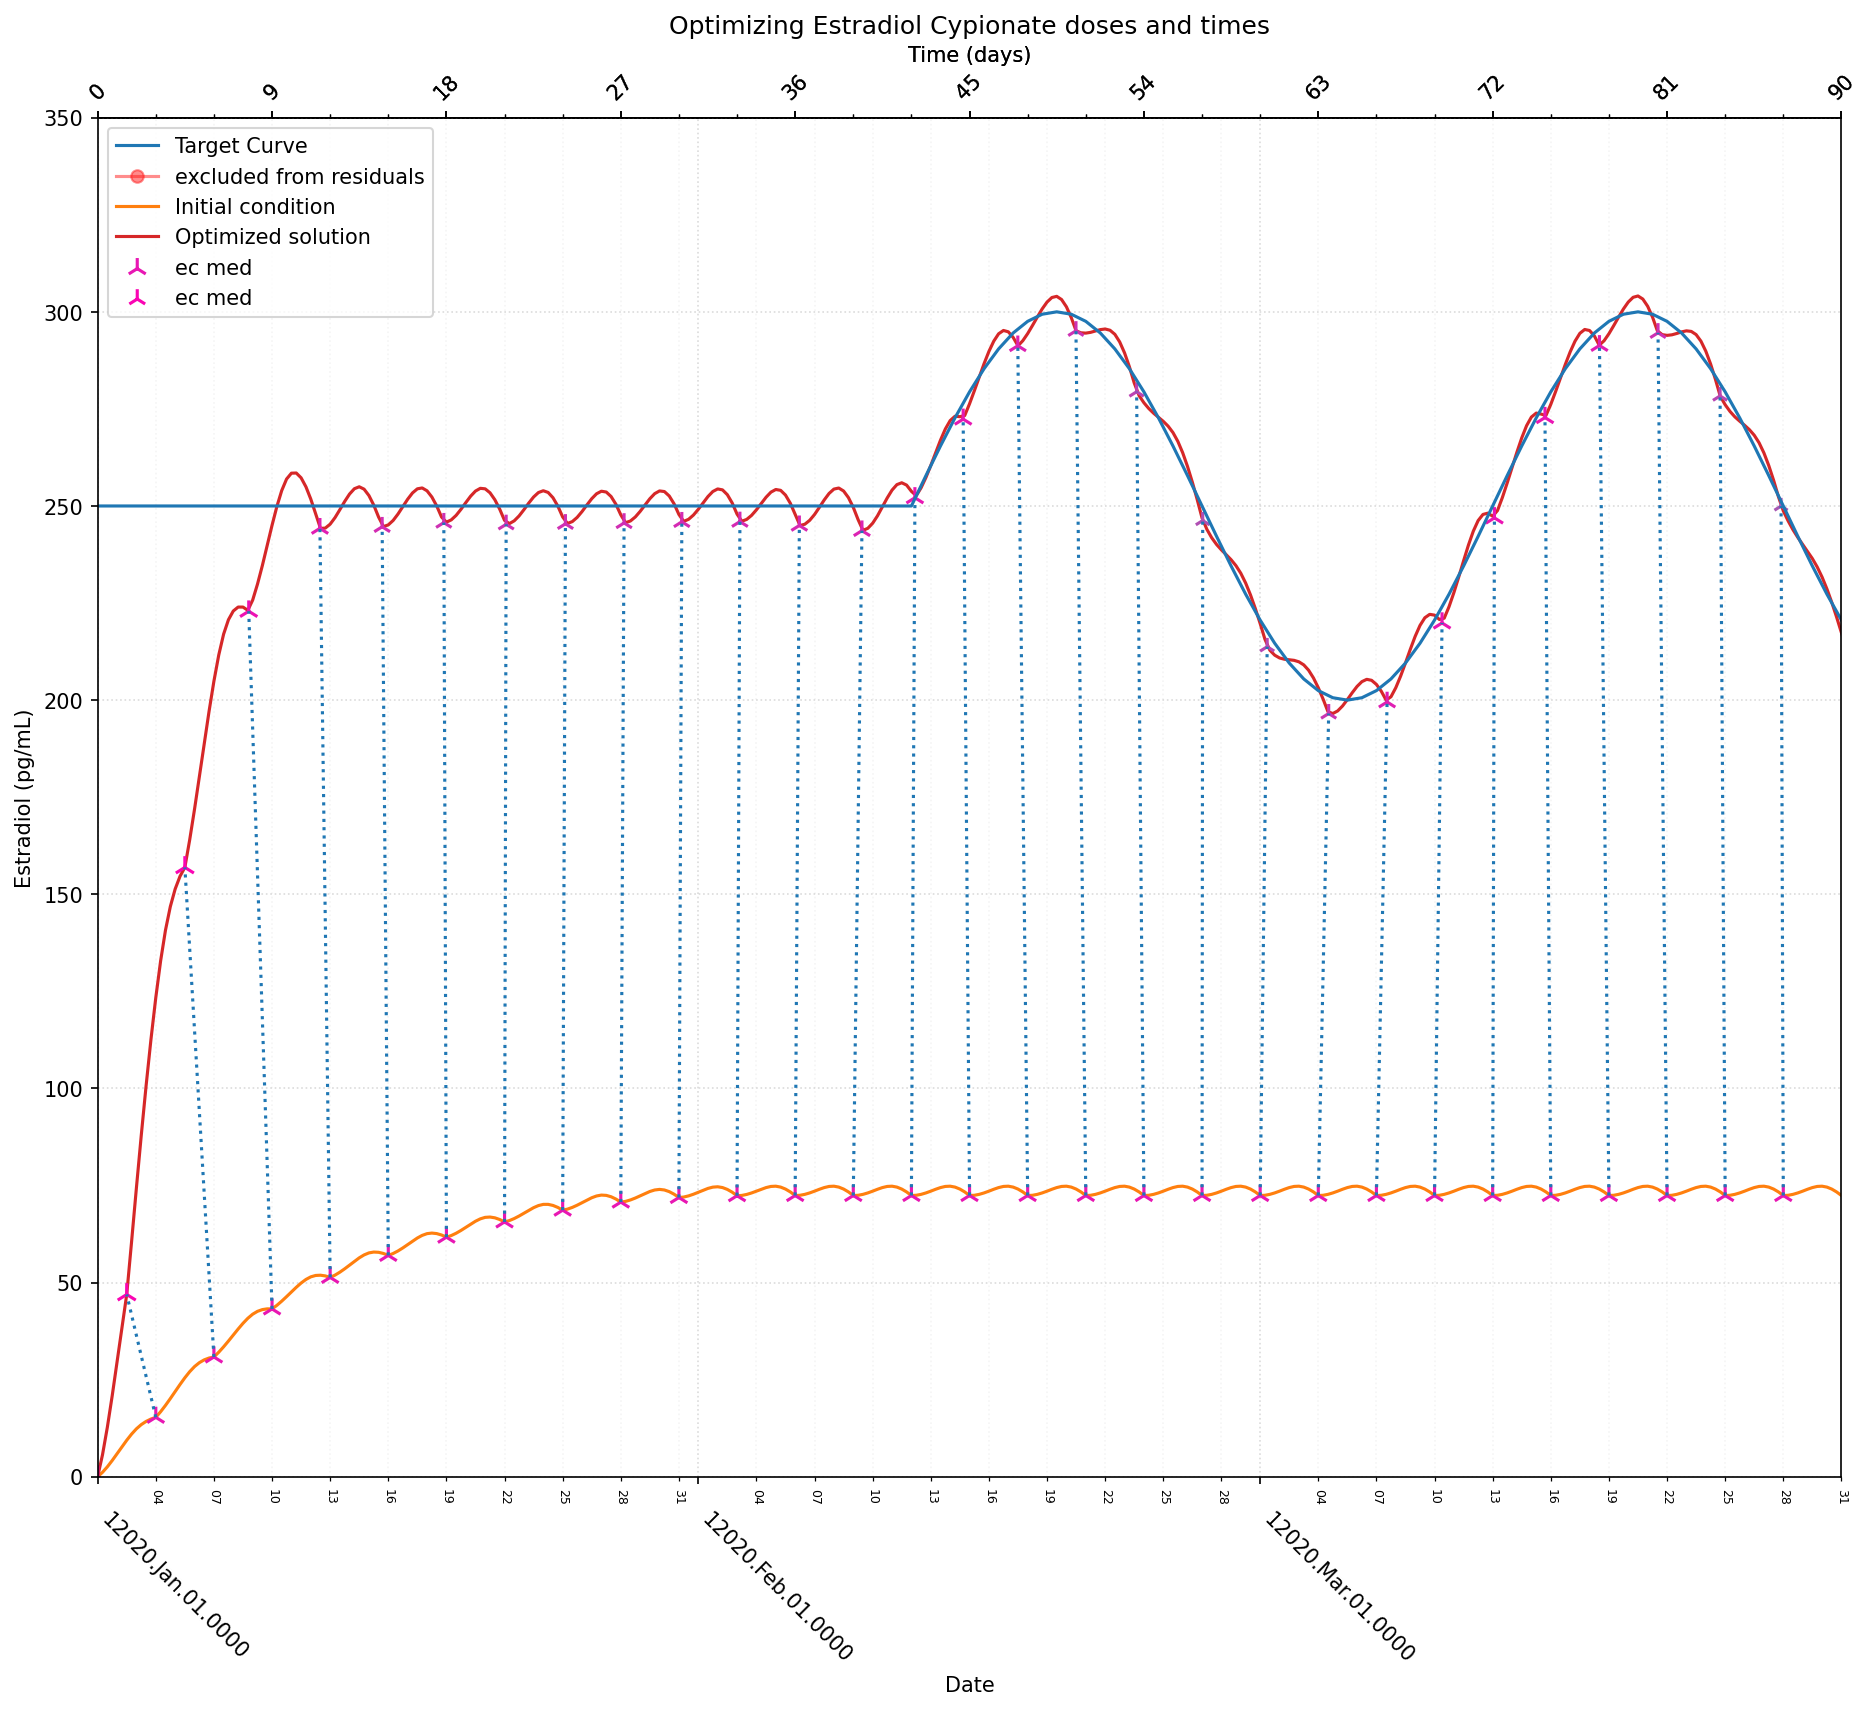

In [20]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses_and_times"]["doses_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [21]:
doses = pharma.createDosesCycle("ev", 90.0, '3D', start_date="2020")
sine_results["ev_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9672e+05                                    2.87e+05    
       1              2         1.0429e+05      9.24e+04       9.44e-01       9.22e+04    
       2              3         9.3201e+04      1.11e+04       4.40e-01       1.89e+04    
       3              4         8.5608e+04      7.59e+03       4.31e-01       4.52e+04    
       4              5         8.3180e+04      2.43e+03       1.74e-01       6.81e+03    
       5              6         7.7732e+04      5.45e+03       5.06e-01       3.61e+04    
       6              7         7.5848e+04      1.88e+03       1.41e-01       4.74e+03    
       7              8         7.3832e+04      2.02e+03       2.85e-01       2.06e+04    
       8              9         7.3240e+04      5.93e+02       9.12e-02       8.48e+03    
       9             10         7.2089e+04      1.15e+03       1.84e-01       1.42e+04    

Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      1.713         ev
2020-01-04 08:34:21.106358400      1.161         ev
2020-01-07 08:23:20.761094400      1.083         ev
2020-01-10 08:31:51.510979200      1.099         ev
2020-01-13 08:49:25.765939200      1.100         ev
2020-01-16 08:46:18.047683200      1.102         ev
2020-01-19 08:45:33.658732800      1.101         ev
2020-01-22 08:45:59.404550400      1.101         ev
2020-01-25 08:46:12.725184000      1.101         ev
2020-01-28 08:46:10.063286400      1.101         ev
2020-01-31 08:46:09.695222400      1.101         ev
2020-02-03 08:46:34.980614400      1.101         ev
2020-02-06 08:50:23.649446400      1.103         ev
2020-02-09 09:07:24.791779200      1.108         ev
2020-02-12 09:27:48.107260800      1.263         ev
2020-02-15 08:25:11.725737599      1.316         ev
2020-02-18 04:04:57.368438400      1.181         ev
2020-02-20 18:38:04.841606400      1.117      

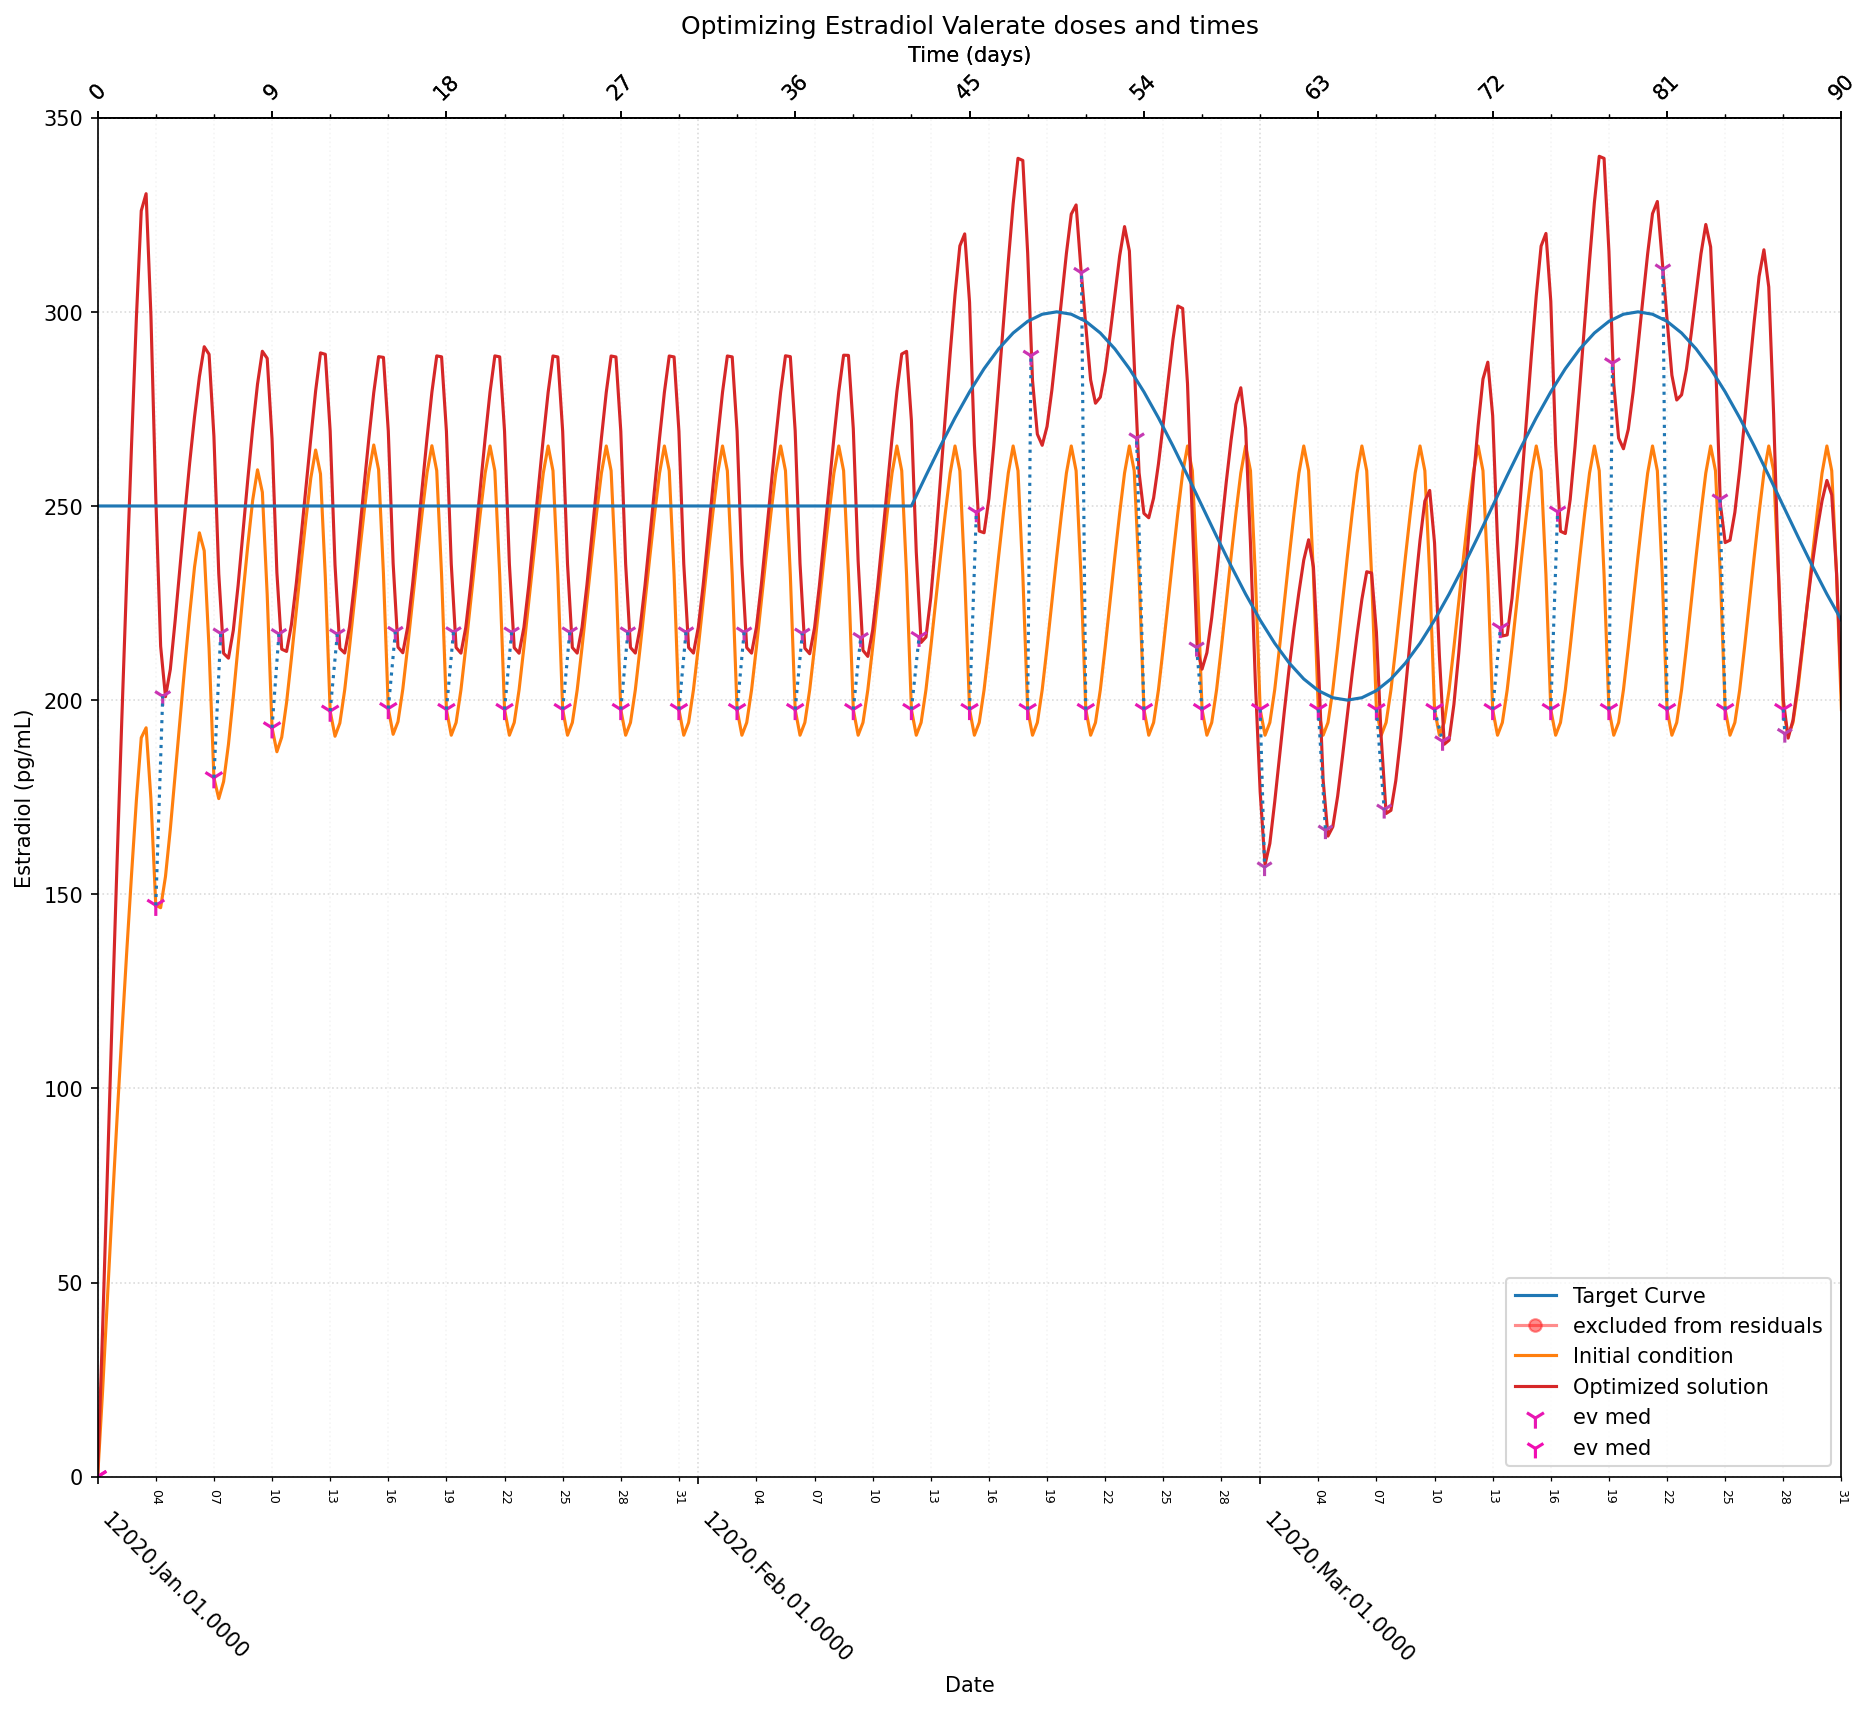

In [22]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Doses:\n", sine_results["ev_doses_and_times"]["doses_optim"])

### Step func (Estradiol Cypionate, optimize doses & times)

It's a loading dose! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [23]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='12H')
step_target_y = np.array([step_func(T) for T in step_target_x])

step_target = pd.Series(step_target_y, index=step_target_x)
step_results = fit.emptyResults()

In [24]:
step_results["ec_doses_and_times"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 62.0, '3D'),
    calibrated_medications,
    step_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=7*['fixed'] + 8*['midpoints'] + 6*['fixed'])
fit.runLeastSquares(
    step_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0659e+06                                    3.09e+05    
       1              2         2.2752e+05      8.38e+05       5.36e+00       6.85e+04    
       2              3         8.3935e+04      1.44e+05       2.59e+00       2.47e+04    
       3              4         4.8634e+04      3.53e+04       1.86e+00       1.34e+04    
       4              5         4.0371e+04      8.26e+03       1.08e+00       8.22e+03    
       5              6         3.4225e+04      6.15e+03       7.31e-01       6.06e+03    
       6              7         3.2156e+04      2.07e+03       4.86e-01       4.75e+03    
       7              8         2.9496e+04      2.66e+03       5.24e-01       5.86e+03    
       8              9         2.8458e+04      1.04e+03       3.19e-01       2.91e+03    
       9             10         2.6533e+04      1.92e+03       5.22e-01       6.47e+03    

Optimized Doses:
                                     dose medication
1970-01-01 00:00:00.000000000      4.975         ec
1970-01-04 00:00:00.000000000      1.567         ec
1970-01-07 00:00:00.000000000      0.923         ec
1970-01-10 00:00:00.000000000      1.467         ec
1970-01-13 00:00:00.000000000      1.496         ec
1970-01-16 00:00:00.000000000      1.295         ec
1970-01-19 00:00:00.000000000      1.109         ec
1970-01-22 05:58:51.721881600      1.281         ec
1970-01-25 20:13:12.815184000      1.852         ec
1970-01-29 11:40:55.417641600      4.679         ec
1970-01-30 10:30:01.061337600      4.925         ec
1970-02-01 17:46:04.454630399      3.641         ec
1970-02-05 21:53:36.493670400      3.588         ec
1970-02-08 20:50:46.040438400      3.667         ec
1970-02-11 17:44:38.970383999      3.434         ec
1970-02-15 00:00:00.000000000      3.178         ec
1970-02-18 00:00:00.000000000      3.146         ec
1970-02-21 00:00:00.000000000      3.291      

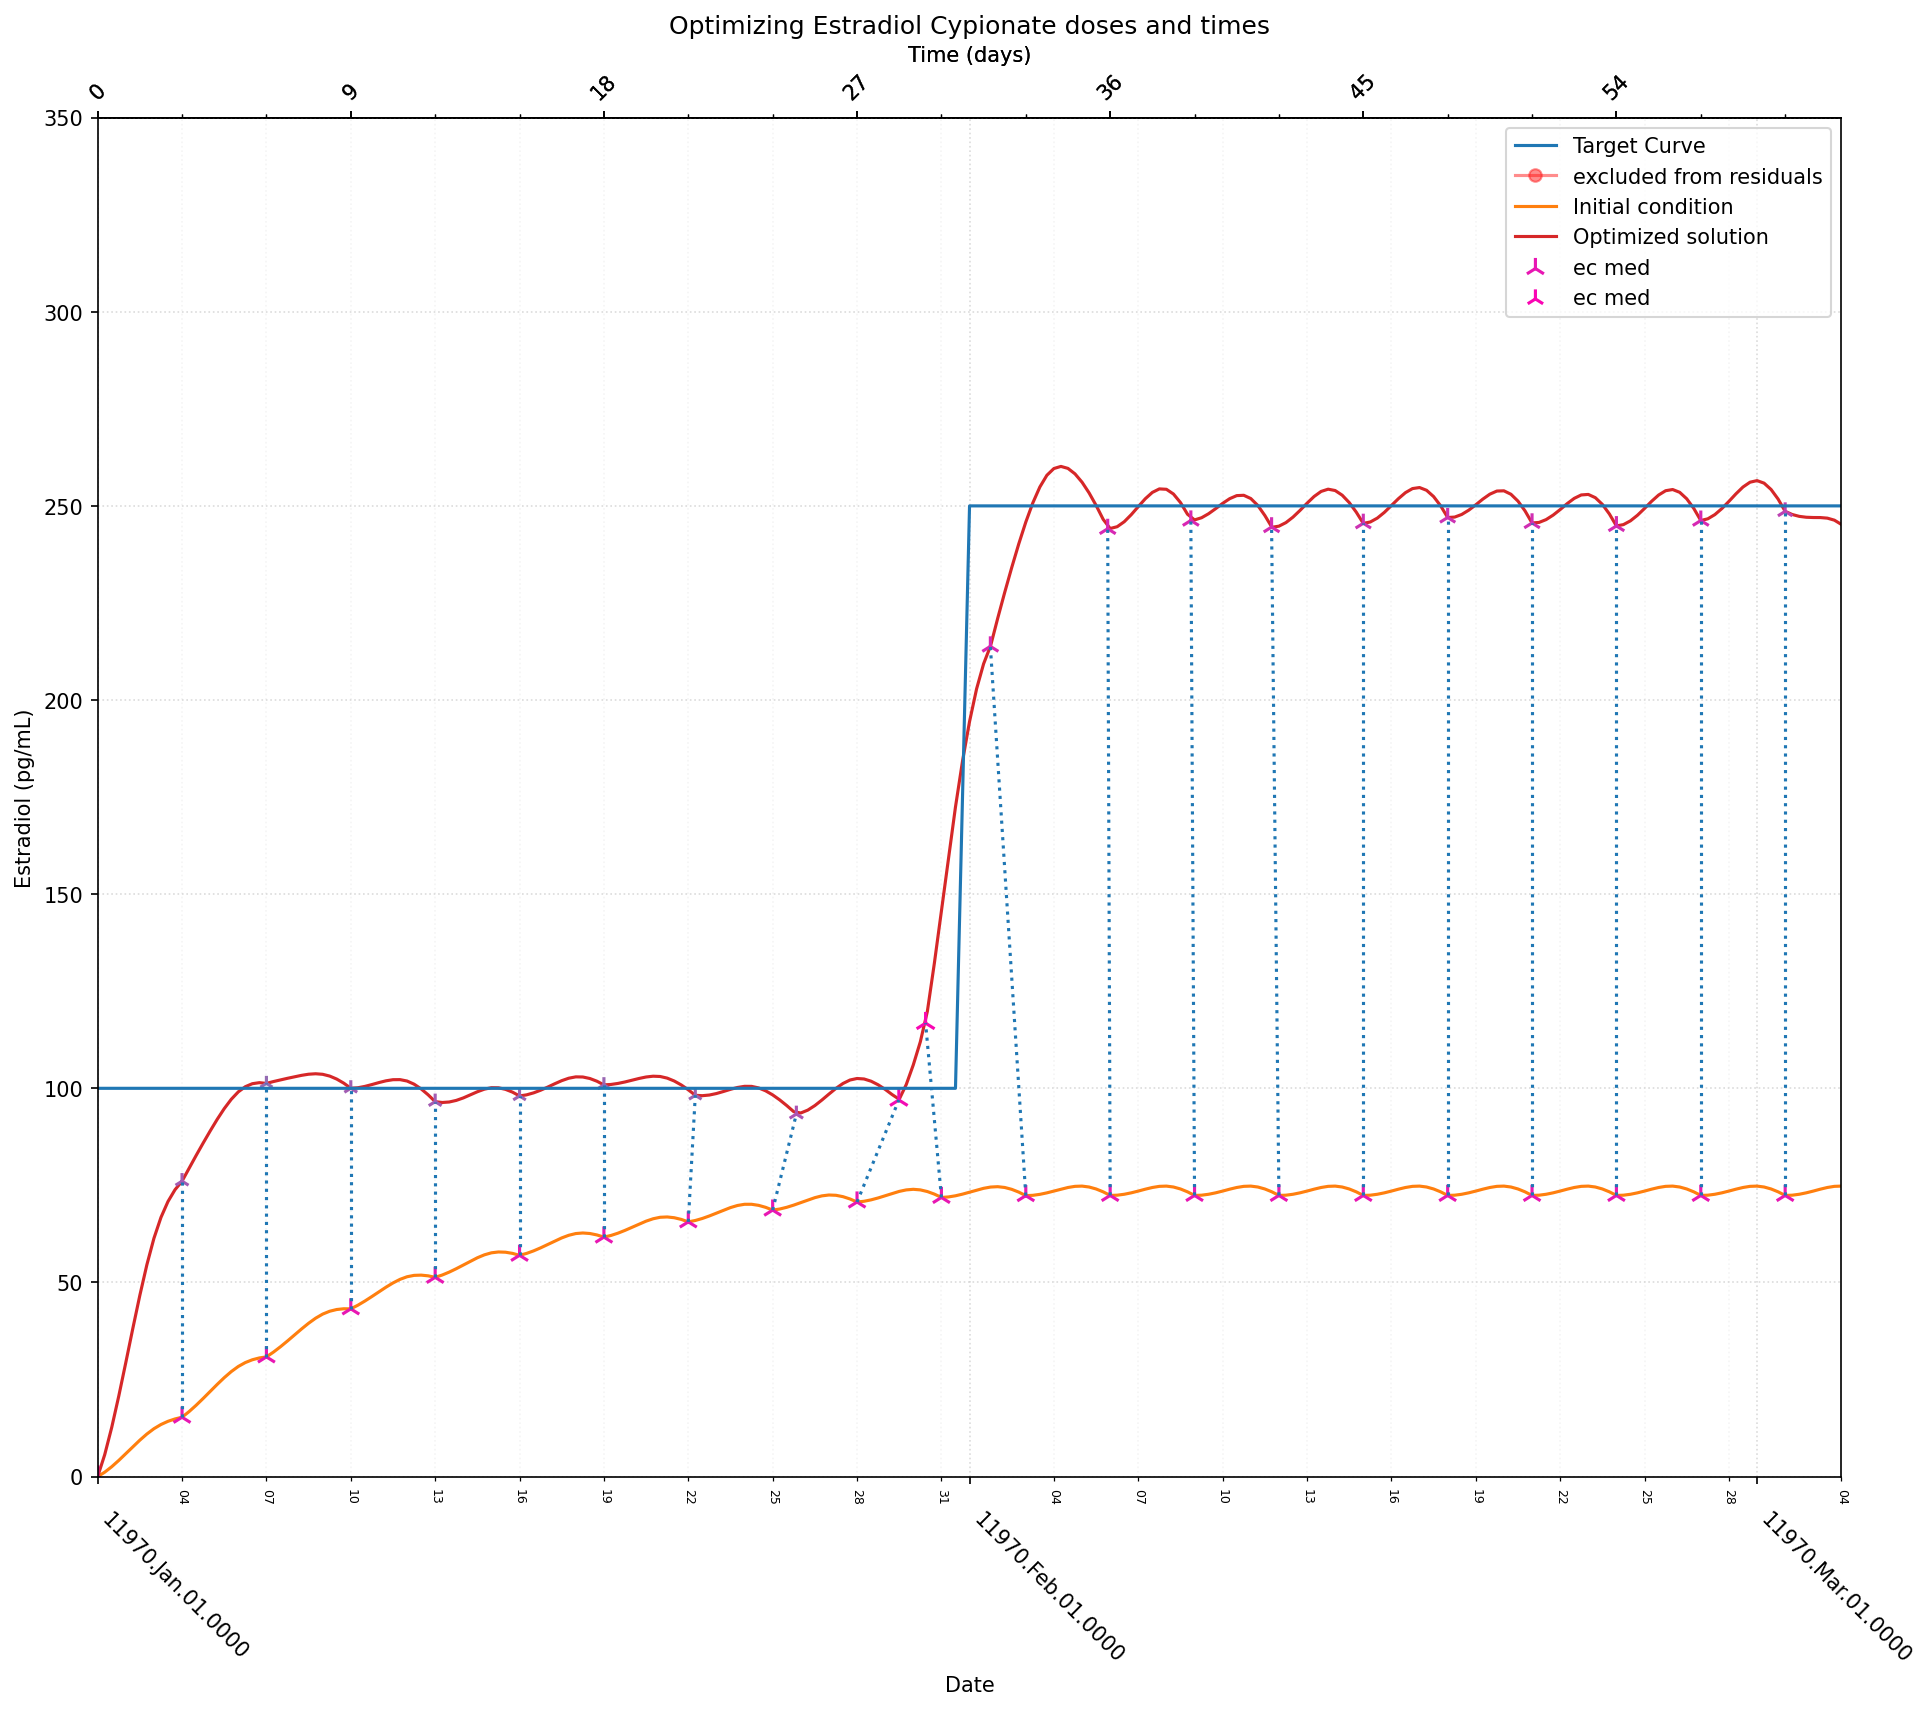

In [25]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", step_results["ec_doses_and_times"]["doses_optim"])